### This dataset has a number of features to predict home price. I will first clean and engineer the data and then fit and compare machine learning models for the regression task. 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load in the data first
train = pd.read_csv('training.csv')
test = pd.read_csv('testing.csv')

In [3]:
# Let's get an overview of the training and test data
print(train.shape)
print(test.shape)
train.info()

(1385, 71)
(1459, 70)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1385 entries, 0 to 1384
Data columns (total 71 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Heating        1385 non-null   object 
 1   HeatingQC      1385 non-null   object 
 2   CentralAir     1385 non-null   object 
 3   Electrical     1384 non-null   object 
 4   1stFlrSF       1385 non-null   int64  
 5   2ndFlrSF       1385 non-null   int64  
 6   GrLivArea      1385 non-null   int64  
 7   BsmtFullBath   1385 non-null   int64  
 8   BsmtHalfBath   1385 non-null   int64  
 9   FullBath       1385 non-null   int64  
 10  HalfBath       1385 non-null   int64  
 11  BedroomAbvGr   1385 non-null   int64  
 12  KitchenAbvGr   1385 non-null   int64  
 13  KitchenQual    1385 non-null   object 
 14  TotRmsAbvGrd   1385 non-null   int64  
 15  Functional     1385 non-null   object 
 16  Fireplaces     1385 non-null   int64  
 17  FireplaceQu    731 non-null   

In [4]:
train['SalePrice'].head() # Pull a sample of the target variable

0     91000
1    135750
2    127000
3    136500
4    110000
Name: SalePrice, dtype: int64

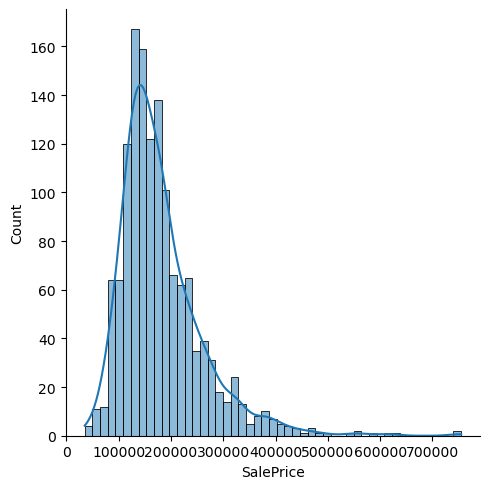

In [5]:
sns.displot(x='SalePrice', data=train, kde=True) #check the distribution of the target variable
# I may try and box-cox transform the target variable so that it is more evenly distributed

/Users/matthewharrison/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SalePrice'>

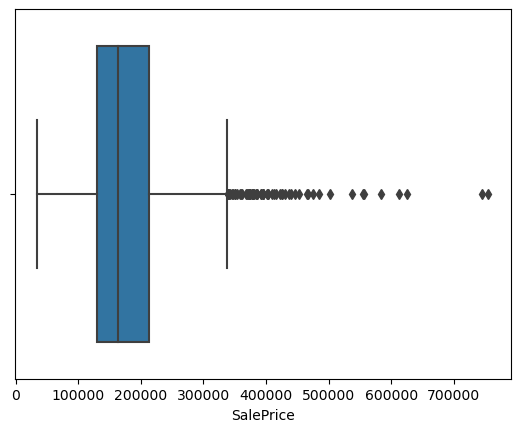

In [6]:
sns.boxplot('SalePrice', data=train)

In [7]:
from scipy.special import boxcox
from scipy import stats

### It looks like the target variable 'SalePrice' is not categorical - I will need a model that predicts this numerical value. Initially, I am thinking Linear Regression (sklearn LinearRegression) is the best option. I will try this first. Then I may try and experiment with Nueral Networks (sklearn MLP and Pytorch), and DT Random Forests (sklearn RandomForestRegressor) and compare performance if we find that they are applicable. 

### Additionally, this dataset has high dimensionality. The first task is to reduce dimensionality and engineer the data so that it is as effective as possible.

## Data Cleaning

In [8]:
# Generate a report of the data using panda profiling
#import pandas_profiling as pp
#profile = pp.ProfileReport(train).to_file(output_file='train.html')
#profile = pp.ProfileReport(test).to_file(output_file='test.html')

In [9]:
### per the report - no missing values or 0's in training data for 'SalePrice' target column. Min = 34,900
### Max = 755,000, Mean = 180,847

In [10]:
## Separate into train, target, and test subsets
train_sub = train.drop('SalePrice', axis=1)
target_sub = train.SalePrice
test_sub = test.copy()

In [11]:
#Segregate numerical and categorical variables
numerical_vars = []
categorical_vars = []
for col in train_sub.columns:
    if train_sub[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
        numerical_vars.append(col)
    elif train_sub[col].dtype == object:
        categorical_vars.append(col)
print('Numerical features: ', numerical_vars)
print('Categorical features: ',categorical_vars)
#Rearrange the data
new_order = numerical_vars + categorical_vars
train_sub = train_sub[new_order]
test_sub = test_sub[new_order]

Numerical features:  ['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'MiscVal', 'MoSold', 'YrSold']
Categorical features:  ['Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'MiscFeature', 'SaleType', 'SaleCondition']


In [12]:
# How many numerical and categorical features are there?
print("There are " + str(len(numerical_vars)) + " numerical features.")
print("There are " + str(len(categorical_vars)) + " categorical features.")

There are 30 numerical features.
There are 40 categorical features.


In [13]:
#Stack the training and testing data so that there are no inconsistencies after data transformation
train_test_data = pd.concat([train_sub, test_sub], axis=0)
train_test_data.shape

(2844, 70)

### Numerical Data 

In [14]:
## First see if there are columns with missing data 
numerical_missing = []
numerical_missing = [col for col in train_test_data[numerical_vars] if train_test_data[col].isnull().any()]
print(numerical_missing)

['BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF']


In [15]:
# how many instances of missing data in these features
num_missing_BsmtFullBath = train_test_data['BsmtFullBath'].isnull().sum()
num_missing_BsmtHalfBath = train_test_data['BsmtHalfBath'].isnull().sum()
num_missing_GarageYrBlt = train_test_data['GarageYrBlt'].isnull().sum()
num_missing_GarageCars = train_test_data['GarageCars'].isnull().sum()
num_missing_MasVnrArea = train_test_data['MasVnrArea'].isnull().sum()
num_missing_BsmtFinSF1 = train_test_data['BsmtFinSF1'].isnull().sum()
num_missing_BsmtUnfSF = train_test_data['BsmtUnfSF'].isnull().sum()
num_missing_TotalBsmtSF = train_test_data['TotalBsmtSF'].isnull().sum()
print("Number of passengers without 'BsmtFullBath': ", num_missing_BsmtFullBath)
print("Number of passengers without 'num_missing_BsmtHalfBath': ", num_missing_BsmtHalfBath)
print("Number of passengers without 'num_missing_GarageYrBlt': ", num_missing_GarageYrBlt)
print("Number of passengers without 'num_missing_GarageCars': ", num_missing_GarageCars)
print("Number of passengers without 'num_missing_MasVnrArea': ", num_missing_MasVnrArea)
print("Number of passengers without 'num_missing_BsmtFinSF1': ", num_missing_BsmtFinSF1)
print("Number of passengers without 'num_missing_BsmtUnfSF': ", num_missing_BsmtUnfSF)
print("Number of passengers without 'num_missing_TotalBsmtSF': ", num_missing_TotalBsmtSF)

Number of passengers without 'BsmtFullBath':  2
Number of passengers without 'num_missing_BsmtHalfBath':  2
Number of passengers without 'num_missing_GarageYrBlt':  157
Number of passengers without 'num_missing_GarageCars':  1
Number of passengers without 'num_missing_MasVnrArea':  23
Number of passengers without 'num_missing_BsmtFinSF1':  1
Number of passengers without 'num_missing_BsmtUnfSF':  1
Number of passengers without 'num_missing_TotalBsmtSF':  1


In [16]:
# Replace all except GarageYrBlt and GarageCars with 0. We will assume these houses do not have a basement or 
# masonry veneer. GarageYrBlt and GarageCars we will insert the median for the missing values.
train_test_data['BsmtFullBath'] = train_test_data['BsmtFullBath'].fillna(0)
train_test_data['BsmtHalfBath'] = train_test_data['BsmtHalfBath'].fillna(0)
train_test_data['MasVnrArea'] = train_test_data['MasVnrArea'].fillna(0)
train_test_data['BsmtFinSF1'] = train_test_data['BsmtFinSF1'].fillna(0)
train_test_data['BsmtUnfSF'] = train_test_data['BsmtUnfSF'].fillna(0)
train_test_data['TotalBsmtSF'] = train_test_data['TotalBsmtSF'].fillna(0)
train_test_data['GarageYrBlt'] = train_test_data['GarageYrBlt'].fillna(train_test_data['GarageYrBlt'].median())
train_test_data['GarageCars'] = train_test_data['GarageCars'].fillna(train_test_data['GarageCars'].median())

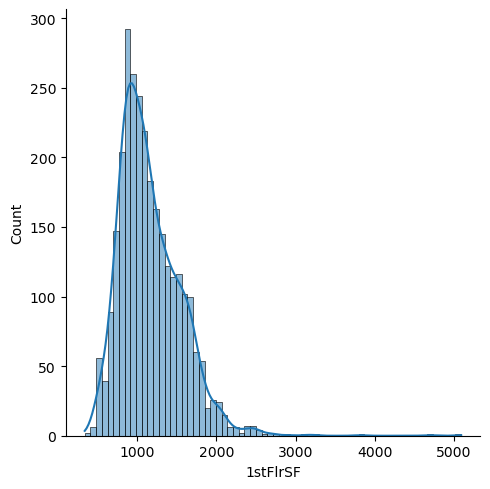

In [17]:
sns.displot(train_test_data['1stFlrSF'], kde=True)

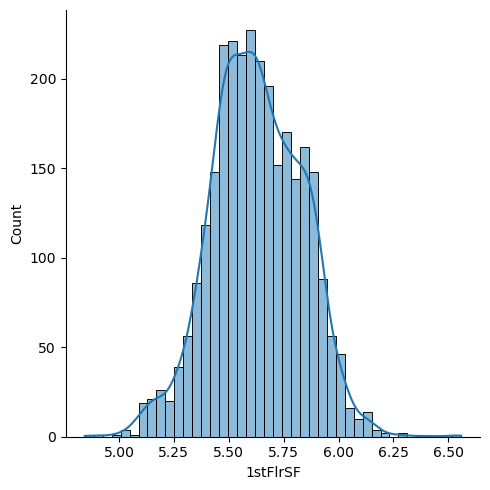

In [18]:
## I am not sure the best process do this, so we are going to handle each feature one by one!
# '1stFlrSF' - box cox transform
a, b = stats.boxcox(train_test_data['1stFlrSF'])
train_test_data = train_test_data.drop('1stFlrSF', axis=1)
train_test_data['1stFlrSF'] = a
sns.displot(train_test_data['1stFlrSF'], kde=True)

/Users/matthewharrison/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='2ndFlrSF', ylabel='Density'>

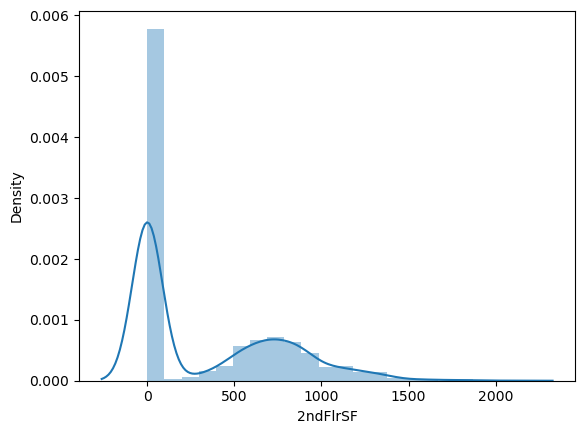

In [19]:
sns.distplot(train_test_data['2ndFlrSF'], kde=True)

In [20]:
# '2ndFlrSF'
# Per pp report it has a high correlation with 0. Let's bin this one to make it categorical.
# I am thinking something like 3 bins. 
train_test_data['2ndFlrSF'] = pd.cut(train_test_data['2ndFlrSF'], [-float("inf"),0,700,float("inf")])

<AxesSubplot:xlabel='2ndFlrSF', ylabel='count'>

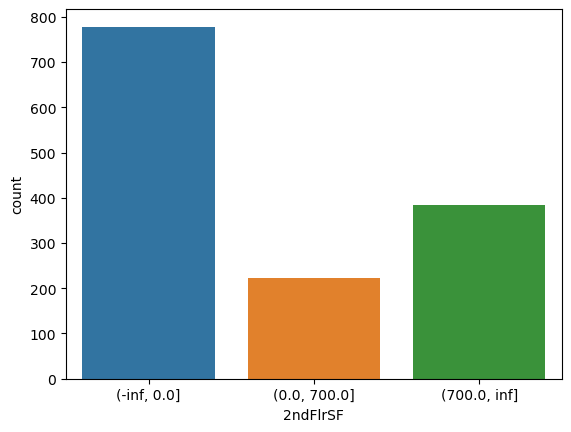

In [21]:
sns.countplot(x='2ndFlrSF', data=train_test_data.iloc[:len(target_sub), :])

In [22]:
# 'GrLivArea' 
# Box-Cox Transform
a, b = stats.boxcox(train_test_data['GrLivArea'])
train_test_data = train_test_data.drop('GrLivArea', axis=1)
train_test_data['GrLivArea'] = a


In [23]:
# 'BsmtFullBath'
# This should be in 2 bins - either 0 or greater than 0. 
train_test_data['BsmtFullBath'] = pd.cut(train_test_data['BsmtFullBath'], [-float("inf"),0,float("inf")])


In [24]:
# 'FullBath' 
# This is mainly 1 and 2 or more so we will split into 2 categories. 
train_test_data['FullBath'] = pd.cut(train_test_data['FullBath'], [-float("inf"),1,float("inf")])

In [25]:
# 'HalfBath'
# Bin to 0 and 1 or more. 
train_test_data['HalfBath'] = pd.cut(train_test_data['HalfBath'], [-float("inf"),0,float("inf")])


In [26]:
# 'BedroomAbvGr'
# We're going to put this in somewhat even bins. 0-2,3,3+
train_test_data['BedroomAbvGr'] = pd.cut(train_test_data['BedroomAbvGr'], [0,2,3,float('inf')])

In [179]:
# These columns should be considered categorical and have high tendency (90%+) towards one category. 
# Or they have a tendency toward 0 for their numberical values.
# Thus, I will delete these columns from the dataset because I do not want them to cause bias and overfitting. 
#'KitchenAbvGr','BsmtHalfBath', '3SsnPorch', 'PoolArea', 'MiscVal'

In [27]:
#'MasVnrArea'
train_test_data['MasVnrArea'] = pd.cut(train_test_data['MasVnrArea'], [-float('inf'),0,float('inf')])

In [28]:
#'ScreenPorch'
train_test_data['ScreenPorch'] = pd.cut(train_test_data['ScreenPorch'], [-float('inf'),0,float('inf')])

In [29]:
# TotRmsAbvGrd
# Put this in bins
train_test_data['TotRmsAbvGrd'] = pd.cut(train_test_data['TotRmsAbvGrd'], [0,4,5,6,7,8,float('inf')])

In [30]:
# 'Fireplaces'
# Bin in 0 or 1+ - basically yes or no.
train_test_data['Fireplaces'] = pd.cut(train_test_data['Fireplaces'], [-float('inf'),0,float('inf')])


In [184]:
# 'GarageYrBlt'
# Make a category because it is not necessarily numerical by nature. 
train_test_data['GarageYrBlt'] = train_test_data['GarageYrBlt'].astype('category')

In [31]:
# 'OpenPorchSF'
# Categorize into has porch or does not have porch.
train_test_data['OpenPorchSF'] = pd.cut(train_test_data['OpenPorchSF'], [-float('inf'),0,float('inf')])


In [186]:
# 'BsmtFinSF1'
# Leave alone due to somewhat normal distribution

In [32]:
# 'BsmtUnfSF'
# Leave alone due to somewhat normal distribution

In [33]:
#'GarageCars'
# Bin into 0,1,2,3+
train_test_data['GarageCars'] = pd.cut(train_test_data['GarageCars'], [-float('inf'),0,1,2,float('inf')])


In [34]:
# "WoodDeckSF"
# Basically we're going to bin this in 2 categories - 0 i.e. no wood deck, >0 yes, wood deck
train_test_data['WoodDeckSF'] = pd.cut(train_test_data['WoodDeckSF'], [-float('inf'),0,float('inf')])


In [35]:
# 'LotArea'
# Box-Cox Transformation
a, b = stats.boxcox(train_test_data['LotArea'])
train_test_data = train_test_data.drop('LotArea', axis=1)
train_test_data['LotArea'] = a


In [36]:
# 'OverallQual'
# Put into bins 
train_test_data['OverallQual'] = pd.cut(train_test_data['OverallQual'], [0,4,5,6,7,8,float('inf')])


In [37]:
# 'OverallCond'
# Put into bins 
train_test_data['OverallCond'] = pd.cut(train_test_data['OverallCond'], [0,5,6,float('inf')])


In [38]:
# 'YearBuilt' 
# Put these into categories by decade
train_test_data['YearBuilt'] = pd.cut(train_test_data['YearBuilt'], [0,1950,1980,2000,float('inf')])


In [39]:
# 'YearRemodAdd'
# Put into category by decade 
train_test_data['YearRemodAdd'] = pd.cut(train_test_data['YearRemodAdd'], [0,1990,float('inf')])


In [40]:
# 'YrSold' + 'MoSold' - these are already categorical by nature. However, I think it would be beneficial 
# to combine these columns into one feature that will better track price changes over time. This will 
# then become a categorical feature with 5 (yr) x 12 (mos) = 60 individual categories. If we are not able to achieve
# this, we will leave these as is. If we leave alone, then the columns will still hopefully reflect cycles in 
# yearly and monthly housing prices. At least make these categorical at first.

train_test_data['YrSold'] = train_test_data['YrSold'].astype('category')
train_test_data['MoSold'] = train_test_data['MoSold'].astype('category')

In [41]:
# 'TotalBsmtSF' - has somewhat even distribution and we do not want to take away significance of 0. Leave as is.

## Categorical Data

In [42]:
categorical_missing = []
categorical_missing = [col for col in train_test_data[categorical_vars] if train_test_data[col].isnull().any()]
print(categorical_missing)
print(len(categorical_missing))

['Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'MiscFeature', 'SaleType']
22


In [43]:
#Replace missing values with 'NA' in features we are not deleting
train_test_data['KitchenQual'] = train_test_data['KitchenQual'].fillna('NA')
train_test_data['Exterior1st'] = train_test_data['Exterior1st'].fillna('NA')
train_test_data['Exterior2nd'] = train_test_data['Exterior2nd'].fillna('NA')
train_test_data['MasVnrType'] = train_test_data['MasVnrType'].fillna('NA')
train_test_data['BsmtQual'] = train_test_data['BsmtQual'].fillna('NA')
train_test_data['Fence'] = train_test_data['Fence'].fillna('NA')

In [44]:
categorical_missing = []
categorical_missing = [col for col in train_test_data[categorical_vars] if train_test_data[col].isnull().any()]
print(categorical_missing)

['Electrical', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'MSZoning', 'Alley', 'Utilities', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'MiscFeature', 'SaleType']


In [45]:
# We are going to remove the following columns due to missing values, bias, or correlation:
# And also delete all columns we had noticed in numerical data:

In [46]:
train_test_data = train_test_data.drop(columns=['Heating', 'Electrical', 'Functional', 'FireplaceQu', 'GarageQual', 'GarageCond', 
                              'PoolQC', 'Street', 'Alley', 'Utilities', 
                              'Condition1', 'Condition2', 
                              'BsmtFinType1', 'MiscFeature', 'MiscVal', 'BsmtExposure',
                              'KitchenAbvGr','BsmtHalfBath', '3SsnPorch','PoolArea', 'LandContour',
                                                'Exterior2nd', 'CentralAir'])

In [47]:
# 'HeatingQC'
# Bin this feature to avoid overfitting.
Heating_list = []
for quality in train_test_data['HeatingQC']:
    if quality == 'Ex':
        Heating_list.append(quality)
        continue
    elif quality == 'TA':
        Heating_list.append(quality)
        continue
    elif quality in ['Gd','Fa','Po']:
        Heating_list.append('GdFaPo')
        continue
train_test_data = train_test_data.drop('HeatingQC', axis=1)
train_test_data['HeatingQC'] = Heating_list
train_test_data['HeatingQC'].value_counts()

Ex        1453
TA         838
GdFaPo     553
Name: HeatingQC, dtype: int64

In [48]:
# 'CentralAir' - delete due to bias

In [49]:
# 'PavedDrive'
Garage_list = []
for garage in train_test_data['PavedDrive']:
    if garage == 'Y':
        Garage_list.append(garage)
        continue
    elif garage != 'Y':
        Garage_list.append('NorP')
        continue
train_test_data = train_test_data.drop('PavedDrive', axis=1)
train_test_data['PavedDrive'] = Garage_list
train_test_data['PavedDrive'].value_counts()


Y       2572
NorP     272
Name: PavedDrive, dtype: int64

In [50]:
#'ExterCond'
Garage_list = []
for garage in train_test_data['ExterCond']:
    if garage == 'TA':
        Garage_list.append(garage)
        continue
    elif garage != 'TA':
        Garage_list.append('NonTA')
        continue
train_test_data = train_test_data.drop('ExterCond', axis=1)
train_test_data['ExterCond'] = Garage_list
train_test_data['ExterCond'].value_counts()


TA       2470
NonTA     374
Name: ExterCond, dtype: int64

In [51]:
#'SaleCondition'
Garage_list = []
for garage in train_test_data['SaleCondition']:
    if garage == 'Normal':
        Garage_list.append(garage)
        continue
    elif garage != 'Normal':
        Garage_list.append('NonNormal')
        continue
train_test_data = train_test_data.drop('SaleCondition', axis=1)
train_test_data['SaleCondition'] = Garage_list
train_test_data['SaleCondition'].value_counts()


Normal       2341
NonNormal     503
Name: SaleCondition, dtype: int64

In [52]:
#'BsmtCond'
Garage_list = []
for garage in train_test_data['BsmtCond']:
    if garage == 'TA':
        Garage_list.append(garage)
        continue
    elif garage != 'TA':
        Garage_list.append('NonTA')
        continue
train_test_data = train_test_data.drop('BsmtCond', axis=1)
train_test_data['BsmtCond'] = Garage_list
train_test_data['BsmtCond'].value_counts()


TA       2536
NonTA     308
Name: BsmtCond, dtype: int64

In [53]:
#'SaleType'
Garage_list = []
for garage in train_test_data['SaleType']:
    if garage == 'WD':
        Garage_list.append(garage)
        continue
    elif garage != 'WD':
        Garage_list.append('NonWD')
        continue
train_test_data = train_test_data.drop('SaleType', axis=1)
train_test_data['SaleType'] = Garage_list
train_test_data['SaleType'].value_counts()


WD       2457
NonWD     387
Name: SaleType, dtype: int64

In [54]:
#'KitchenQual' 
Garage_list = []
for garage in train_test_data['KitchenQual']:
    if garage == 'TA':
        Garage_list.append(garage)
        continue
    elif garage != 'TA':
        Garage_list.append('Non-TA')
        continue
train_test_data = train_test_data.drop('KitchenQual', axis=1)
train_test_data['KitchenQual'] = Garage_list
train_test_data['KitchenQual'].value_counts()


TA        1454
Non-TA    1390
Name: KitchenQual, dtype: int64

In [55]:
# 'BsmtQual'
Garage_list = []
for garage in train_test_data['BsmtQual']:
    if garage == 'TA':
        Garage_list.append(garage)
        continue
    elif garage != 'TA':
        Garage_list.append('Non-TA')
        continue
train_test_data = train_test_data.drop('BsmtQual', axis=1)
train_test_data['BsmtQual'] = Garage_list
train_test_data['BsmtQual'].value_counts()


Non-TA    1596
TA        1248
Name: BsmtQual, dtype: int64

In [56]:
# 'Fence'
Garage_list = []
for garage in train_test_data['Fence']:
    if garage == 'NA':
        Garage_list.append(garage)
        continue
    elif garage != 'NA':
        Garage_list.append('Has fence')
        continue
train_test_data = train_test_data.drop('Fence', axis=1)
train_test_data['Fence'] = Garage_list
train_test_data['Fence'].value_counts()


NA           2291
Has fence     553
Name: Fence, dtype: int64

In [57]:
#'MSZoning'
Garage_list = []
for garage in train_test_data['MSZoning']:
    if garage == 'RL':
        Garage_list.append(garage)
        continue
    elif garage != 'RL':
        Garage_list.append('Non-RL')
        continue
train_test_data = train_test_data.drop('MSZoning', axis=1)
train_test_data['MSZoning'] = Garage_list
train_test_data['MSZoning'].value_counts()


RL        2205
Non-RL     639
Name: MSZoning, dtype: int64

In [58]:
# 'GarageType'
# Bin this feature to eliminate small values
Garage_list = []
for garage in train_test_data['GarageType']:
    if garage == 'Attchd':
        Garage_list.append(garage)
        continue
    elif garage != 'Attchd':
        Garage_list.append('Non-Attached or NA')
        continue
train_test_data = train_test_data.drop('GarageType', axis=1)
train_test_data['GarageType'] = Garage_list
train_test_data['GarageType'].value_counts()

Attchd                1676
Non-Attached or NA    1168
Name: GarageType, dtype: int64

In [59]:
# 'GarageFinish'
# Bin this feature to eliminate small values
Garage_list = []
for garage in train_test_data['GarageFinish']:
    if garage == 'Unf':
        Garage_list.append(garage)
        continue
    elif garage != 'Unf':
        Garage_list.append('Finished')
        continue
train_test_data = train_test_data.drop('GarageFinish', axis=1)
train_test_data['GarageFinish'] = Garage_list
train_test_data['GarageFinish'].value_counts()

Finished    1645
Unf         1199
Name: GarageFinish, dtype: int64

In [60]:
# 'LotShape'
# Bin
Lot_list = []
for lot in train_test_data['LotShape']:
    if lot == 'Reg':
        Lot_list.append(lot)
        continue
    elif lot != 'Reg':
        Lot_list.append('Non-Reg')
        continue
train_test_data = train_test_data.drop('LotShape', axis=1)
train_test_data['LotShape'] = Lot_list
train_test_data['LotShape'].value_counts()

Reg        1814
Non-Reg    1030
Name: LotShape, dtype: int64

In [61]:
# 'LandContour' - biased, so delete

In [62]:
# 'LotConfig'
# Bin to reduce bias
Lot_list = []
for lot in train_test_data['LotConfig']:
    if lot == 'Inside':
        Lot_list.append(lot)
        continue
    elif lot == 'Corner':
        Lot_list.append(lot)
        continue
    elif lot in ['CulDSac','FR2','FR3']:
        Lot_list.append('Other')
        continue
train_test_data = train_test_data.drop('LotConfig', axis=1)
train_test_data['LotConfig'] = Lot_list
train_test_data['LotConfig'].value_counts()

Inside    2085
Corner     493
Other      266
Name: LotConfig, dtype: int64

In [63]:
# 'Neighborhood' - I should do something to this - or delete it. It seems to overfit. I will try just one-hot encoding
# so that it keeps identity per neighborhood. Ideally, we will still want this to have influence on sale price
# because with our domain-knowledge - location does influence housing prices. 

In [64]:
# 'BldgType' 
# Bin 
bldg_list = []
for lot in train_test_data['BldgType']:
    if lot == '1Fam':
        bldg_list.append(lot)
        continue
    elif lot != '1Fam':
        bldg_list.append('Non-1Fam')
        continue
train_test_data = train_test_data.drop('BldgType', axis=1)
train_test_data['BldgType'] = bldg_list
train_test_data['BldgType'].value_counts()

1Fam        2360
Non-1Fam     484
Name: BldgType, dtype: int64

In [65]:
# 'HouseStyle'
# Bin to reduce bias
bldg_list = []
for lot in train_test_data['HouseStyle']:
    if lot == '1Story':
        bldg_list.append(lot)
        continue
    elif lot != '1Story':
        bldg_list.append('2Story and others')
        continue
train_test_data = train_test_data.drop('HouseStyle', axis=1)
train_test_data['HouseStyle'] = bldg_list
train_test_data['HouseStyle'].value_counts()

1Story               1426
2Story and others    1418
Name: HouseStyle, dtype: int64

In [66]:
# 'RoofStyle'
bldg_list = []
for lot in train_test_data['RoofStyle']:
    if lot == 'Gable':
        bldg_list.append(lot)
        continue
    elif lot != 'Gable':
        bldg_list.append('Non-Gable')
        continue
train_test_data = train_test_data.drop('RoofStyle', axis=1)
train_test_data['RoofStyle'] = bldg_list
train_test_data['RoofStyle'].value_counts()

Gable        2249
Non-Gable     595
Name: RoofStyle, dtype: int64

In [67]:
#'Exterior1st'
bldg_list = []
for lot in train_test_data['Exterior1st']:
    if lot == 'VinylSd':
        bldg_list.append(lot)
        continue
    elif lot == 'HdBoard':
        bldg_list.append(lot)
        continue
    elif lot == 'MetalSd':
        bldg_list.append(lot)
        continue
    elif lot == 'Wd Sdng':
        bldg_list.append(lot)
        continue
    elif lot != ['VinylSd', 'HdBoard', 'MetalSd', 'WdSdng']:
        bldg_list.append('Other')
        continue
train_test_data = train_test_data.drop('Exterior1st', axis=1)
train_test_data['Exterior1st'] = bldg_list
train_test_data['Exterior1st'].value_counts()

VinylSd    996
Other      577
MetalSd    437
HdBoard    433
Wd Sdng    401
Name: Exterior1st, dtype: int64

In [68]:
#'MasVnrType'
bldg_list = []
for lot in train_test_data['MasVnrType']:
    if lot == 'None':
        bldg_list.append(lot)
        continue
    elif lot != 'None':
        bldg_list.append('Has masonry')
        continue
train_test_data = train_test_data.drop('MasVnrType', axis=1)
train_test_data['MasVnrType'] = bldg_list
train_test_data['MasVnrType'].value_counts()

None           1696
Has masonry    1148
Name: MasVnrType, dtype: int64

In [69]:
#'ExterQual'
bldg_list = []
for lot in train_test_data['ExterQual']:
    if lot == 'TA':
        bldg_list.append(lot)
        continue
    elif lot != 'TA':
        bldg_list.append('FaGdEx')
        continue
train_test_data = train_test_data.drop('ExterQual', axis=1)
train_test_data['ExterQual'] = bldg_list
train_test_data['ExterQual'].value_counts()

TA        1749
FaGdEx    1095
Name: ExterQual, dtype: int64

In [70]:
#'Foundation'
bldg_list = []
for lot in train_test_data['Foundation']:
    if lot == 'PConc':
        bldg_list.append(lot)
        continue
    elif lot == 'CBlock':
        bldg_list.append(lot)
        continue
    elif lot != ['Cblock','PConc']:
        bldg_list.append('Other')
        continue
train_test_data = train_test_data.drop('Foundation', axis=1)
train_test_data['Foundation'] = bldg_list
train_test_data['Foundation'].value_counts()

PConc     1276
CBlock    1203
Other      365
Name: Foundation, dtype: int64

In [71]:
# 'SaleCondition' - pretty biased towards normal so we will delete this one.

In [72]:
# Label Encode categorical data that has heirarchy - i.e. numerical that was changed to categorical

In [73]:
from sklearn.preprocessing import LabelEncoder
label_encode_vars = ['2ndFlrSF','BsmtFullBath', 'FullBath','HalfBath','BedroomAbvGr','TotRmsAbvGrd','Fireplaces',
                    'GarageYrBlt','GarageCars','WoodDeckSF','OpenPorchSF','ScreenPorch','OverallQual','OverallCond',
                    'YearBuilt','YearRemodAdd','MoSold','YrSold','MasVnrArea']
label_encoder = LabelEncoder()
for col in label_encode_vars:
    train_test_data[col] = label_encoder.fit_transform(train_test_data[col])

In [74]:
#One-Hot Encode other categorical features
onehot_encode_vars = ['HeatingQC','KitchenQual','BsmtQual','Fence','MSZoning','GarageType','GarageFinish','Neighborhood',
                    'LotShape','LotConfig','BldgType','HouseStyle','RoofStyle','Exterior1st','MasVnrType',
                    'ExterQual','Foundation','PavedDrive', 'ExterCond', 'BsmtCond', 'SaleType','SaleCondition']
train_test_data = pd.get_dummies(data=train_test_data, columns=onehot_encode_vars)

In [75]:
#Now, seperate the training and testing sets from train_test_features
X_train = train_test_data.iloc[:len(target_sub), :]
X_test = train_test_data.iloc[len(target_sub):, :]
y_train = target_sub.copy()
#Join the training data and the target feature
X_training_data = pd.concat([X_train, y_train], axis=1)
print(X_training_data.shape)
print(X_test.shape)

(1385, 99)
(1459, 98)


In [76]:
# Remove features with predominant 0 values 
features_to_be_dropped = []
for col in X_train.columns:
    val_counts = X_train[col].value_counts()
    zero_counts = val_counts.iloc[0]
    if (zero_counts / X_train.shape[0] > 0.98):
        features_to_be_dropped.append(col)
print(features_to_be_dropped)
X_train = X_train.drop(features_to_be_dropped, axis=1).copy()
print(X_train.shape)
X_test = X_test.drop(features_to_be_dropped, axis=1).copy()
print(X_test.shape)
X_training_data = X_training_data.drop(features_to_be_dropped, axis=1).copy()
print(X_training_data.shape)

['Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_ClearCr', 'Neighborhood_MeadowV', 'Neighborhood_NPkVill', 'Neighborhood_SWISU', 'Neighborhood_StoneBr', 'Neighborhood_Veenker']
(1385, 89)
(1459, 89)
(1385, 90)


In [77]:
# Standardize data with StandardScaler 
from sklearn.preprocessing import StandardScaler
X_train = pd.DataFrame(StandardScaler().fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(StandardScaler().fit_transform(X_test), columns=X_test.columns)
X_training_data = pd.concat([X_train, y_train], axis=1)
X_training_data = X_training_data.iloc[:-1,:]

## Machine Learning

### Linear Regression

In [78]:
from sklearn.model_selection import train_test_split

In [79]:
# Split into 80% train and test 
from sklearn.model_selection import train_test_split
X_train_full, X_valid_full, y_train_full, y_valid_full = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, random_state=42)
print(X_train_full.shape)
print(X_valid_full.shape)

(1108, 89)
(277, 89)


In [80]:
#Vanilla Linear Regression
from sklearn.linear_model import LinearRegression

In [81]:
lm = LinearRegression()
lm.fit(X_train_full, y_train_full)

LinearRegression()

In [82]:
predictions = lm.predict(X_valid_full)

In [83]:
#from scipy.special import inv_boxcox

In [84]:
#y_valid_actual = inv_boxcox(y_valid_full, 0)
#predictions_actual = inv_boxcox(predictions, 0)

In [85]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_valid_full, predictions))
print('MSE:', metrics.mean_squared_error(y_valid_full, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid_full, predictions)))

MAE: 22073.760418537535
MSE: 1686289160.3901055
RMSE: 41064.45129780874


In [87]:
## So we can essentially guess house price within about $40k. There seems to be an outlier causing issues.
## As well as the higher end priced houses that effect the model. 
## Ideally we would like to normalize the target variable prior to modeling in order to deal with outliers. 

In [88]:
#Cross Validation Function
import scipy.stats as st
from sklearn.model_selection import cross_val_score
def cross_val_stats(X_train, y_train, model, cv):
    scores = cross_val_score(model, X_train, y_train, cv=cv)
    lower_cl, upper_cl = st.t.interval(alpha=0.95, df=cv-1, loc=np.mean(scores), scale=st.sem(scores))
    print('Scores: ', scores)
    print('Mean: ', np.mean(scores))
    print('95% Confidence Interval: [{}, {}]'.format(lower_cl.round(4), upper_cl.round(4)))

#Cross Validate the logistic model (Correct way)
lin_model = LinearRegression()
cross_val_stats(X_train_full, y_train_full, lin_model, 10)

Scores:  [0.85807097 0.79724656 0.84880557 0.65059367 0.90160267 0.78362896
 0.81529775 0.8632517  0.83310751 0.86503685]
Mean:  0.8216642222589143
95% Confidence Interval: [0.7719, 0.8714]


In [89]:
## Ridge Regression
from sklearn.linear_model import Ridge
rm = Ridge()

In [90]:
rm.fit(X_train_full, y_train_full)

Ridge()

In [91]:
ridge_predictions = rm.predict(X_valid_full)

In [92]:
print('MAE:', metrics.mean_absolute_error(y_valid_full, ridge_predictions))
print('MSE:', metrics.mean_squared_error(y_valid_full, ridge_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid_full, ridge_predictions)))

MAE: 22065.89297182039
MSE: 1684893506.5591772
RMSE: 41047.454324953906


In [93]:
#Cross Validate the ridge model 
ridge_model = Ridge()
cross_val_stats(X_train_full, y_train_full, ridge_model, 10)

Scores:  [0.85812854 0.79732507 0.84882734 0.65102492 0.90176534 0.7835264
 0.81555429 0.86323316 0.83328235 0.86526964]
Mean:  0.8217937041868393
95% Confidence Interval: [0.7721, 0.8715]


In [94]:
## Slightly better performance, but pretty much the same.

In [95]:
# Lasso Linear Regression
from sklearn.linear_model import Lasso

In [96]:
import warnings
warnings.filterwarnings('ignore')
lasso = Lasso()
lasso.fit(X_train_full, y_train_full)
lasso_predictions = lasso.predict(X_valid_full)

In [97]:
print('MAE:', metrics.mean_absolute_error(y_valid_full, lasso_predictions))
print('MSE:', metrics.mean_squared_error(y_valid_full, lasso_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid_full, lasso_predictions)))

MAE: 22071.60700504311
MSE: 1686042346.1314442
RMSE: 41061.44598198466


In [98]:
#Cross Validate the lasso model (Correct way)
lasso_model = Lasso()
cross_val_stats(X_train_full, y_train_full, lasso_model, 10)

Scores:  [0.85805891 0.79730555 0.84881469 0.65064924 0.90162276 0.78361604
 0.8153234  0.86331247 0.83311633 0.86509667]
Mean:  0.8216916068153346
95% Confidence Interval: [0.7719, 0.8714]


In [99]:
## Pretty much the same performance again for the lasso model. Let's see if we can gridsearch for the 

### RandomForest Regression

In [100]:
from sklearn.ensemble import RandomForestRegressor
rf_mod = RandomForestRegressor(random_state=42).fit(X_train_full, y_train_full)
rf_valid_preds = rf_mod.predict(X_valid_full)

print('MAE:', metrics.mean_absolute_error(y_valid_full, rf_valid_preds))
print('MSE:', metrics.mean_squared_error(y_valid_full, rf_valid_preds))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid_full, rf_valid_preds)))

#Cross validate the random forest model
rf_mod = RandomForestRegressor(random_state=42)
cross_val_stats(X_train_full, y_train_full, rf_mod, 10)

MAE: 19295.62772563177
MSE: 1172315532.684257
RMSE: 34239.093631173375
Scores:  [0.86756202 0.84327216 0.87887644 0.55155348 0.90416911 0.86266648
 0.88445806 0.90259469 0.81807058 0.88431729]
Mean:  0.8397540292872782
95% Confidence Interval: [0.7649, 0.9146]


In [101]:
##Increasing n_estimators to 500
rf_mod = RandomForestRegressor(random_state=42, n_estimators=500).fit(X_train_full, y_train_full)
rf_valid_preds = rf_mod.predict(X_valid_full)

print('MAE:', metrics.mean_absolute_error(y_valid_full, rf_valid_preds))
print('MSE:', metrics.mean_squared_error(y_valid_full, rf_valid_preds))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid_full, rf_valid_preds)))

#Cross validate the random forest model
rf_mod2 = RandomForestRegressor(random_state=42, n_estimators=500)
cross_val_stats(X_train_full, y_train_full, rf_mod2, 10)

MAE: 19146.31442599278
MSE: 1076789815.402731
RMSE: 32814.475699037626
Scores:  [0.87739469 0.84041935 0.87730022 0.55851559 0.90455033 0.86000747
 0.88596589 0.90823708 0.82707252 0.89023501]
Mean:  0.8429698129037009
95% Confidence Interval: [0.7691, 0.9168]


In [102]:
## Slightly better performance.

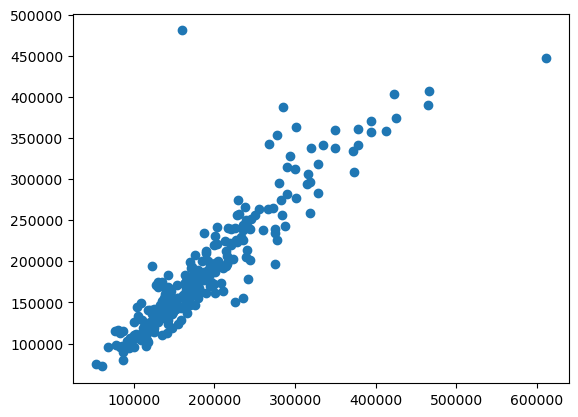

In [103]:
plt.scatter(y_valid_full,rf_valid_preds)

### Support Vector Machine

In [106]:
#Fit basic model first. Then we will hypertune to see if we can improve performance
from sklearn.svm import SVR
svr = SVR()
svr.fit(X_train_full, y_train_full)
svr_preds = svr.predict(X_valid_full)
print('MAE:', metrics.mean_absolute_error(y_valid_full, svr_preds))
print('MSE:', metrics.mean_squared_error(y_valid_full, svr_preds))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid_full, svr_preds)))
cross_val_stats(X_train_full, y_train_full, svr, 10)

MAE: 56819.363830292335
MSE: 6872084377.769055
RMSE: 82898.0360308316
Scores:  [-0.02681948 -0.08577259 -0.02948727 -0.05913076 -0.02654207 -0.03799751
 -0.01370109 -0.1138873  -0.10049655 -0.09472265]
Mean:  -0.05885572796873266
95% Confidence Interval: [-0.0852, -0.0325]


In [107]:
##GridSearch
#param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 
#grid = GridSearchCV(SVR(),param_grid,refit=True,verbose=3)
#grid.fit(X_train,y_train)
#grid.best_params_
#output {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}

In [108]:
svr_gr = SVR(C=1000, gamma = 0.01, kernel = 'rbf')
svr_gr.fit(X_train_full, y_train_full)
svr_preds2 = svr_gr.predict(X_valid_full)
print('MAE:', metrics.mean_absolute_error(y_valid_full, svr_preds2))
print('MSE:', metrics.mean_squared_error(y_valid_full, svr_preds2))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid_full, svr_preds2)))
cross_val_stats(X_train_full, y_train_full, svr_gr, 10)

MAE: 37217.62342930096
MSE: 3915167643.564498
RMSE: 62571.30047845017
Scores:  [0.36708135 0.27990318 0.34931265 0.38377673 0.41085371 0.27079266
 0.54838062 0.32702963 0.38684299 0.43242692]
Mean:  0.3756400423461258
95% Confidence Interval: [0.3183, 0.433]


In [109]:
## Better performance after gridsearch, but SVM does not give optimal performance.

### Gradient Boosted Trees

In [110]:
from xgboost import XGBRegressor
xgb_mod = XGBRegressor(random_state=42)
xgb_mod.fit(X_train_full, y_train_full)
xgb_preds = xgb_mod.predict(X_valid_full)
print('MAE:', metrics.mean_absolute_error(y_valid_full, xgb_preds))
print('MSE:', metrics.mean_squared_error(y_valid_full, xgb_preds))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid_full, xgb_preds)))
cross_val_stats(X_train, y_train, xgb_mod, 10)

MAE: 19790.3764666065
MSE: 1032598059.696039
RMSE: 32134.06385280329
Scores:  [0.89680723 0.8887296  0.90281351 0.70969706 0.87469519 0.79106054
 0.89658091 0.88575386 0.89101425 0.85367597]
Mean:  0.8590828116427529
95% Confidence Interval: [0.8147, 0.9034]


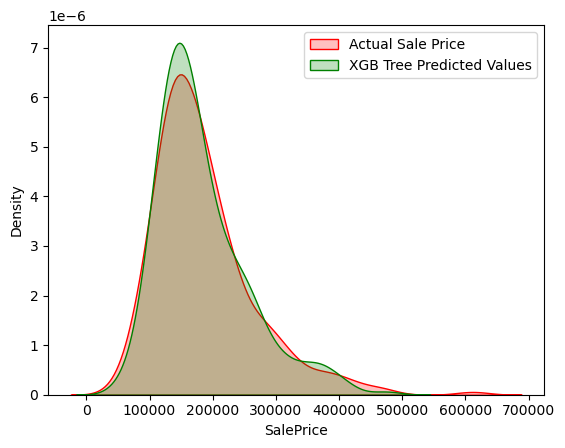

In [111]:
fig = sns.kdeplot(y_valid_full, shade=True, color='r')
fig = sns.kdeplot(xgb_preds, shade=True, color='g')
fig.legend(labels=['Actual Sale Price','XGB Tree Predicted Values'])
plt.show()

In [112]:
# Best performance so far. This is the best confidence interval we have achieved - this is the most 
# consistent model. Next we will try Gridsearch to tune the parameters. 

In [113]:
#xgb = XGBRegressor(random_state=42)
#grid = GridSearchCV(xgb, cv=5, n_jobs=4, param_grid={
#    'n_estimators':[5,10,20,50],
#    'gamma':[0.8,0.5,0.9],
#    'learning_rate':[1,0.5,0.1,0.05,0.01,],
#    'subsample':[0.8,0.5,0.7,0.9],
#    'max_depth': [1,2,3,4,5]})
#grid.fit(X_train, y_train)

###OUTPUT######
#grid.best_params_
#{'gamma': 0.8,
# 'learning_rate': 0.1,
# 'max_depth': 4,
# 'n_estimators': 50,
# 'subsample': 0.7}

In [114]:
## Check performance with gridsearch parameters
xgb_mod = XGBRegressor(gamma=0.8, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.7, random_state=42)
xgb_mod.fit(X_train_full, y_train_full)
xgb_preds2 = xgb_mod.predict(X_valid_full)
print('MAE:', metrics.mean_absolute_error(y_valid_full, xgb_preds2))
print('MSE:', metrics.mean_squared_error(y_valid_full, xgb_preds2))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid_full, xgb_preds2)))
cross_val_stats(X_train, y_train, xgb_mod, 10)

MAE: 18243.790543208484
MSE: 1005829724.6070575
RMSE: 31714.81869106392
Scores:  [0.89603718 0.90863485 0.92097941 0.6891041  0.86600681 0.80039515
 0.89410638 0.86007786 0.88264499 0.86832239]
Mean:  0.8586309134782649
95% Confidence Interval: [0.8098, 0.9074]


In [115]:
# Pretty good performance as well. 

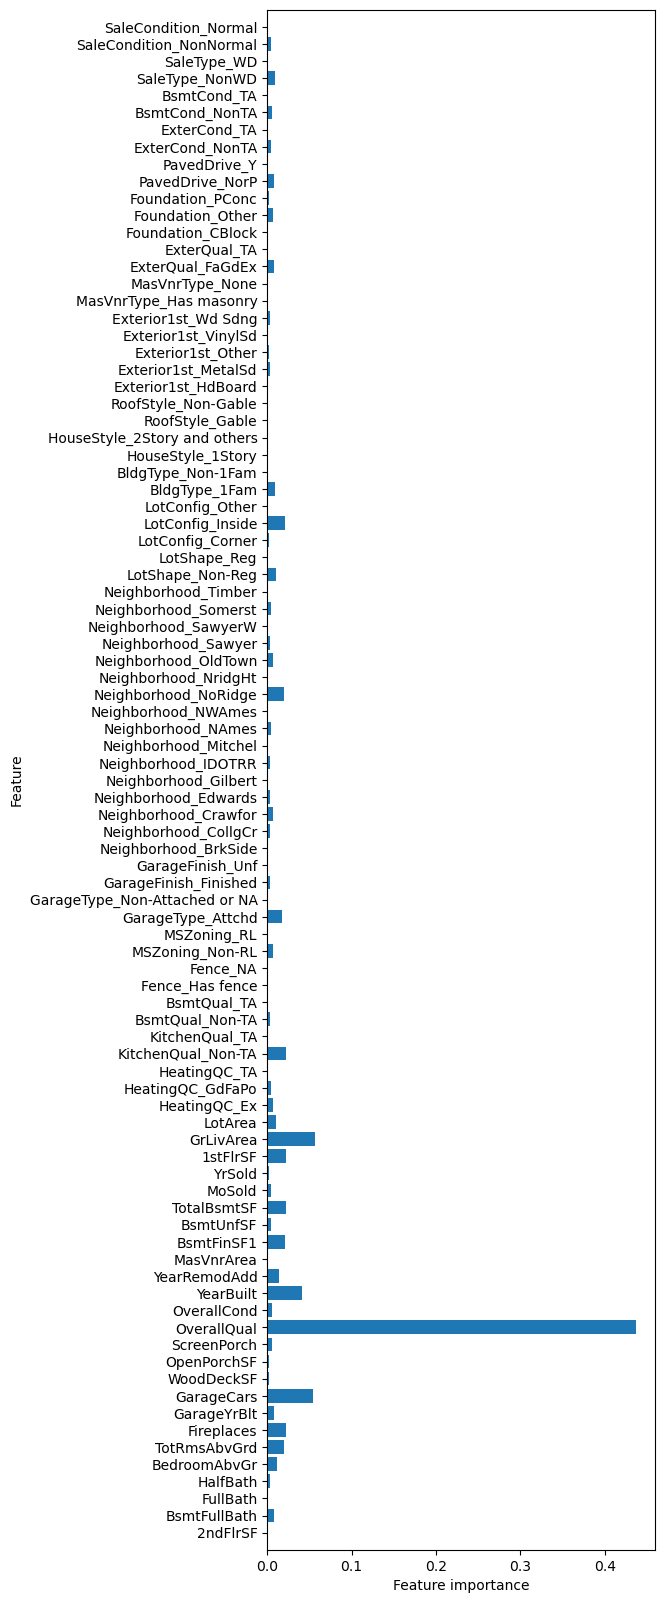

In [117]:
#Lets look at our feature importances
plot_feature_importances(xgb_mod)

In [118]:
## This distribution of feature importance here is also high on OverallQual, but a little more even. After deleting 
## 'OverallQual' it seems like the feature importances are more varied.

In [119]:
## However, the best mean 95% interval is given by the standard XGBRegressor. This is the best model we have found
## thus far. Let's now train this model on the full training set and get our predictions on the test set. 

### Logistic Regression

In [120]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train_full, y_train_full)
logpreds = logmodel.predict(X_valid_full)
print('MAE:', metrics.mean_absolute_error(y_valid_full, logpreds))
print('MSE:', metrics.mean_squared_error(y_valid_full, logpreds))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid_full, logpreds)))
cross_val_stats(X_train, y_train, logmodel, 10)

MAE: 33124.06498194946
MSE: 2518325385.971119
RMSE: 50182.91926513561
Scores:  [0.02158273 0.02877698 0.         0.02877698 0.00719424 0.
 0.00724638 0.         0.         0.00724638]
Mean:  0.010082368887498697
95% Confidence Interval: [0.0016, 0.0186]


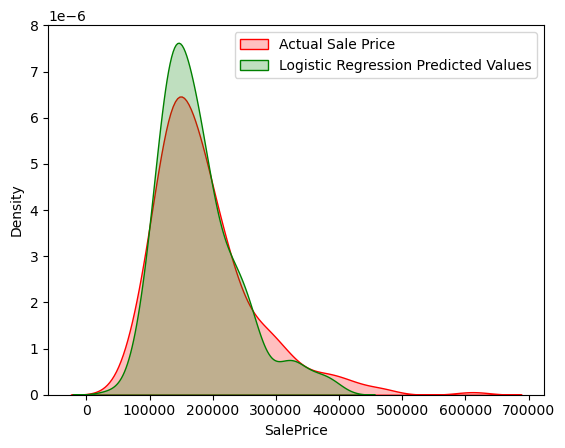

In [121]:
fig = sns.kdeplot(y_valid_full, shade=True, color='r')
fig = sns.kdeplot(logpreds, shade=True, color='g')
fig.legend(labels=['Actual Sale Price','Logistic Regression Predicted Values'])
plt.show()

### KNN

<AxesSubplot:title={'center':'RMSE vs. K Value'}, xlabel='K value', ylabel='RMSE (SalePrice)'>

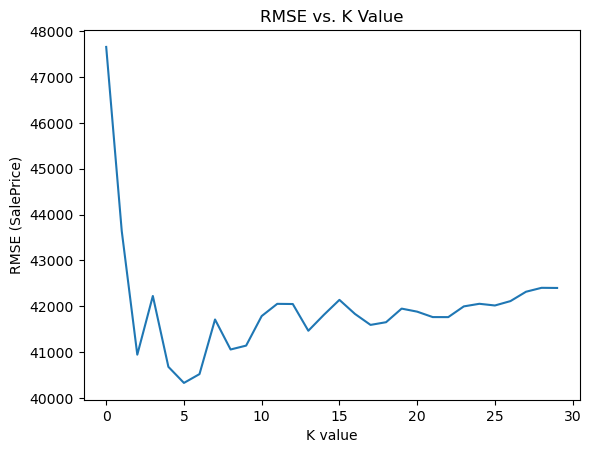

In [122]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import neighbors
rmse_val = []
for K in range(30):
    K = K+1
    knnmodel = neighbors.KNeighborsRegressor(n_neighbors = K)
    knnmodel.fit(X_train_full, y_train_full)
    knnpred=knnmodel.predict(X_valid_full) 
    error = np.sqrt(metrics.mean_squared_error(y_valid_full, knnpred))
    rmse_val.append(error)
curve = pd.DataFrame(rmse_val)
curve.plot(title='RMSE vs. K Value', legend=False, xlabel='K value', ylabel='RMSE (SalePrice)')

In [124]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_full, y_train_full)
knn_preds = knn_model.predict(X_valid_full)
print('MAE:', metrics.mean_absolute_error(y_valid_full, knn_preds))
print('MSE:', metrics.mean_squared_error(y_valid_full, knn_preds))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid_full, knn_preds)))
cross_val_stats(X_train, y_train, knn_model, 10)

MAE: 26586.549458483754
MSE: 1654636988.56852
RMSE: 40677.22936199711
Scores:  [0.72554745 0.78993132 0.84454201 0.70506637 0.66985271 0.78001957
 0.81761716 0.75952246 0.58382514 0.77395422]
Mean:  0.7449878408299424
95% Confidence Interval: [0.6901, 0.7999]


### Decision Tree 

In [125]:
from sklearn.tree import DecisionTreeRegressor
dt_mod = DecisionTreeRegressor(random_state=42).fit(X_train_full, y_train_full)
dt_valid_preds = dt_mod.predict(X_valid_full)

print('MAE:', metrics.mean_absolute_error(y_valid_full, dt_valid_preds))
print('MSE:', metrics.mean_squared_error(y_valid_full, dt_valid_preds))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid_full, dt_valid_preds)))

#Cross validate the random forest model
dt_mod = RandomForestRegressor(random_state=42)
cross_val_stats(X_train_full, y_train_full, dt_mod, 10)

MAE: 27280.87003610108
MSE: 1590083190.6101084
RMSE: 39875.84720868145
Scores:  [0.86756202 0.84327216 0.87887644 0.55155348 0.90416911 0.86266648
 0.88445806 0.90259469 0.81807058 0.88431729]
Mean:  0.8397540292872782
95% Confidence Interval: [0.7649, 0.9146]


### Retrain XGBRegressor on whole training set and predict on test set

In [ ]:
xgbr_mod = XGBRegressor(random_state=42)
xgbr_mod.fit(X_train, y_train)
xgbr_preds = xgbr_mod.predict(X_test)

In [ ]:
submissions = pd.DataFrame(xgbr_preds)

In [ ]:
print(submissions.shape)
print(X_test.shape)

In [ ]:
submissions.to_csv('submissions.csv')